In [25]:
from pathlib import Path
import random
import cv2
import xml.etree.ElementTree as ET
import shutil
import tqdm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

import time
import os
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

In [2]:
shutil.rmtree('training_demo/images/train')
shutil.rmtree('training_demo/images/test')

Path('training_demo/images/train/').mkdir(exist_ok= True, parents = True)
Path('training_demo/images/test').mkdir(exist_ok= True, parents = True)

In [3]:
import pdb

In [6]:
for cls in ['banana_red', 'apple_kashmir']:
    cls_dataset = []
    for xml_path in Path(f'object_detection_dataset/{cls}').glob('*.xml'):
        name = xml_path.stem
        img_path = xml_path.parent / (name+'.jpg')
        img = cv2.imread(str(img_path))
        if img.shape == (2208, 4608, 3):
            cls_dataset.append((img_path, xml_path))
            
    random.seed(0)
    random.shuffle(cls_dataset)
    train_split = cls_dataset[:int(len(cls_dataset)*.9)]
    test_split = cls_dataset[int(len(cls_dataset)*.9):]
    
    for img_path, xml_path in train_split:
        shutil.copy(img_path, 'training_demo/images/train/')
        shutil.copy(xml_path, 'training_demo/images/train/')
    
    for img_path, xml_path in test_split:
        shutil.copy(img_path, 'training_demo/images/test/')
        shutil.copy(xml_path, 'training_demo/images/test/')

In [7]:
new_width = 640
new_height = 320

def resize_xml(tree):
    root = tree.getroot()
    width = int(root.find('size').find('width').text)
    height = int(root.find('size').find('height').text)
    
    root.find('size').find('width').text = str(new_width)
    root.find('size').find('height').text = str(new_height)
    
    for obj in root.iter('object'):
        name = obj.find('name').text
        box = obj.find('bndbox')
        x_min = int(box.find('xmin').text); y_min = int(box.find('ymin').text)
        x_max = int(box.find('xmax').text); y_max = int(box.find('ymax').text)
        box.find('xmin').text = str(int(float(x_min) / width * new_width))
        box.find('xmax').text = str(int(float(x_max) / width * new_width))
        box.find('ymin').text = str(int(float(y_min) / height * new_height))
        box.find('ymax').text = str(int(float(y_max) / height * new_height))

def resize_img(img, new_width, new_height):
    resized_img = cv2.resize(img, (new_width, new_height))
    return resized_img

# train

In [8]:
xml_files = list(Path('training_demo/images/train').glob('*.xml'))
for file in tqdm.tqdm(xml_files):
    # resize xml
    tree = ET.parse(str(file))
    root = tree.getroot()
    filename = root.find('filename').text  
    if root.find('folder').text == 'Apple Kashmir':
        root.find('folder').text = 'apple_kashmir'
    root.find('path').text = str((file.parent / (str(file.stem)+'.jpg')).resolve())
    resize_xml(tree)
    tree.write(str(file))
    
    # resize img
    img_path = file.parent / (file.stem+'.jpg')
    img = cv2.imread(str(img_path))
    resized_img = resize_img(img, new_width, new_height)
    cv2.imwrite(str(img_path), resized_img)

100%|███████████████████████████████████████████████████████████████████████| 122/122 [00:14<00:00,  8.69it/s]


# test

In [9]:
xml_files = list(Path('training_demo/images/test').glob('*.xml'))
for file in tqdm.tqdm(xml_files):
    # resize xml
    tree = ET.parse(str(file))
    root = tree.getroot()
    filename = root.find('filename').text    
    if root.find('folder').text == 'Apple Kashmir':
        root.find('folder').text = 'apple_kashmir'
    root.find('path').text = str((file.parent / (str(file.stem)+'.jpg')).resolve())
    resize_xml(tree)
    tree.write(str(file))
    
    # resize img
    img_path = file.parent / (file.stem+'.jpg')
    img = cv2.imread(str(img_path))
    resized_img = resize_img(img, new_width, new_height)
    cv2.imwrite(str(img_path), resized_img)

100%|█████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00,  8.22it/s]


### Use the exported trained model for predictions

In [2]:
def load_image_into_numpy_array(path):
    return np.array(Image.open(path))

In [15]:
PATH_TO_MODEL_DIR = 'training_demo/exported-models/my_model'
PATH_TO_CFG = PATH_TO_MODEL_DIR + "/pipeline.config"
PATH_TO_CKPT = PATH_TO_MODEL_DIR + "/checkpoint"
PATH_TO_LABELS = 'training_demo/annotations/label_map.pbtxt'

print('Loading model... ', end='')
start_time = time.time()

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(PATH_TO_CFG)
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(PATH_TO_CKPT, 'ckpt-0')).expect_partial()

@tf.function
def detect_fn(image):
    """Detect objects in image."""

    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)

    return detections

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading model... Done! Took 0.22620797157287598 seconds


In [16]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,
                                                                    use_display_name=True)

Running inference for training_demo/images/test/IMG_20211016_104545.jpg... Done
Running inference for training_demo/images/test/IMG_20211016_103510.jpg... Done
Running inference for training_demo/images/test/IMG_20211016_103511_2.jpg... Done
Running inference for training_demo/images/test/IMG_20211016_104520.jpg... Done
Running inference for training_demo/images/test/IMG_20211016_104538.jpg... Done
Running inference for training_demo/images/test/IMG_20211016_103531.jpg... Done
Running inference for training_demo/images/test/IMG_20211016_103525.jpg... Done
Running inference for training_demo/images/test/IMG_20211016_104533_BURST001_COVER.jpg... Done
Running inference for training_demo/images/test/IMG_20211016_104728.jpg... Done
Running inference for training_demo/images/test/IMG_20211016_104503.jpg... Done
Running inference for training_demo/images/test/IMG_20211016_103656.jpg... Done
Running inference for training_demo/images/test/IMG_20211016_103723.jpg... Done
Running inference for t

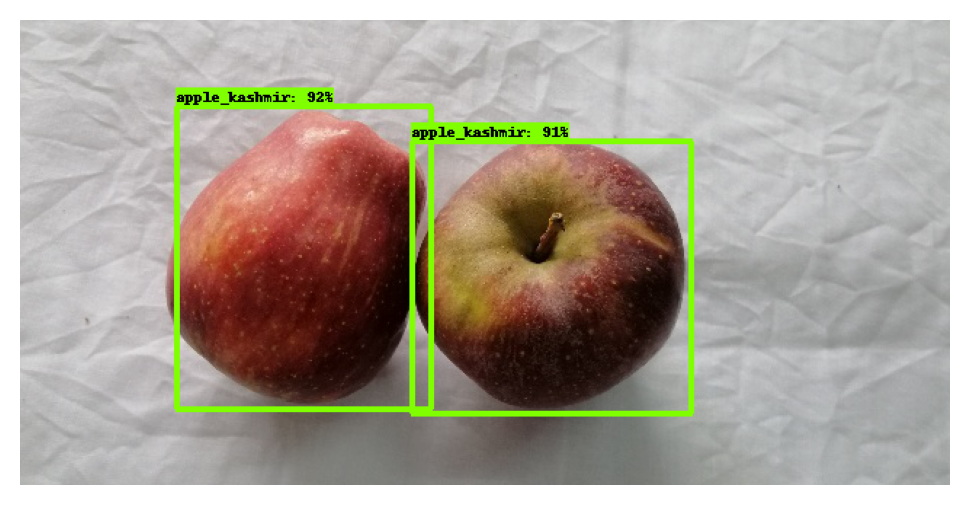

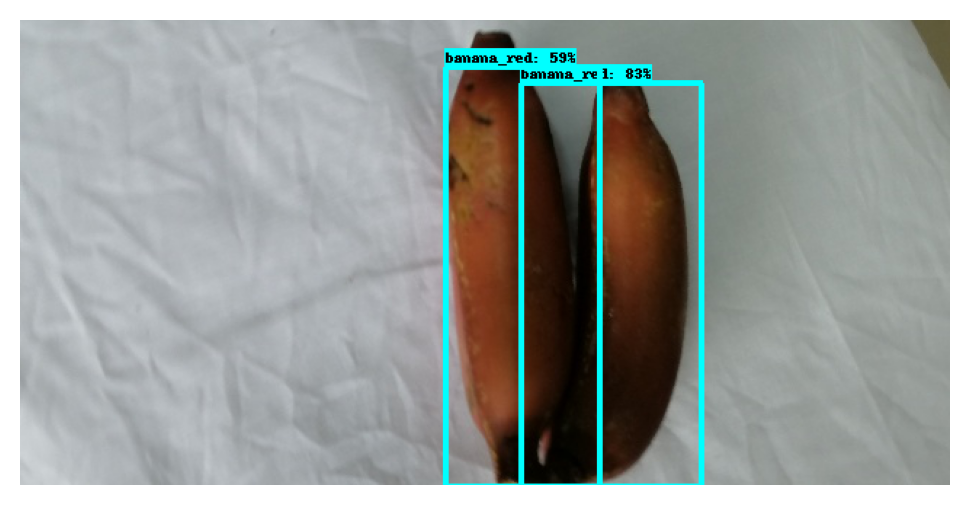

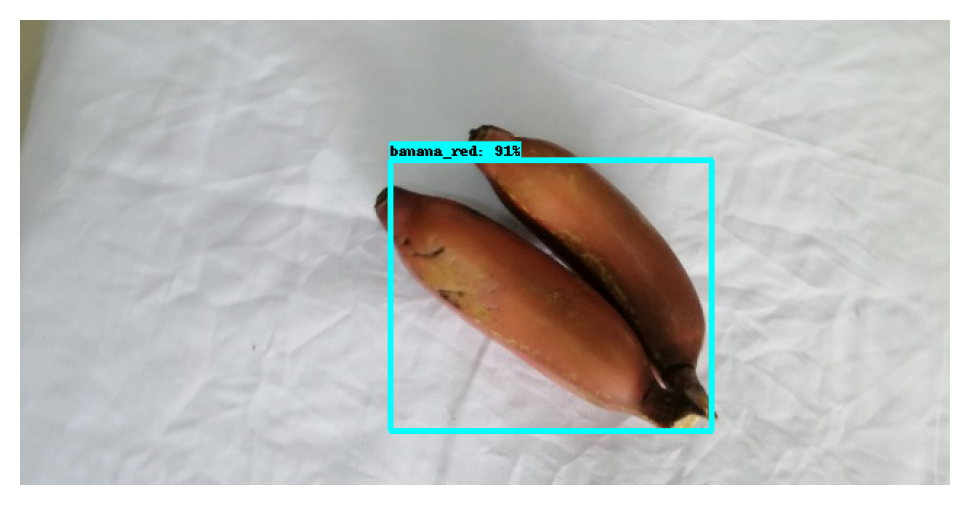

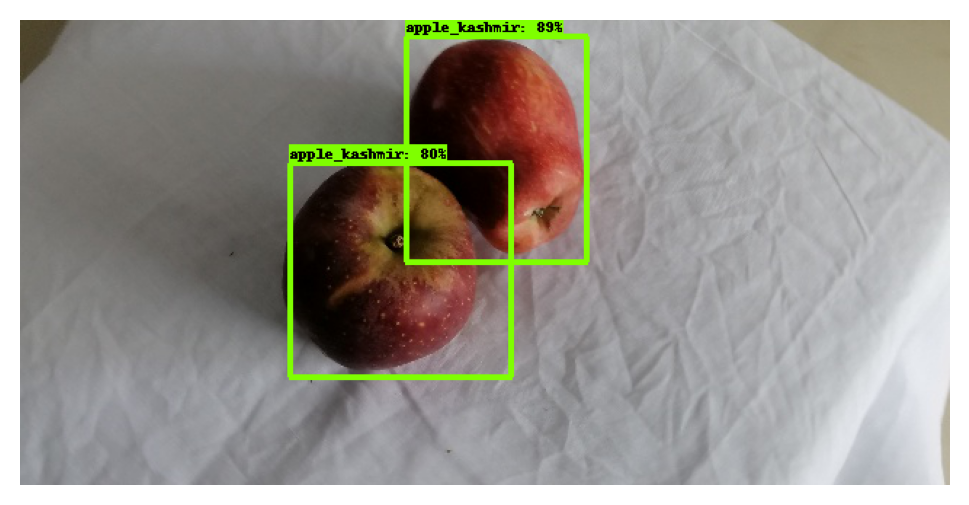

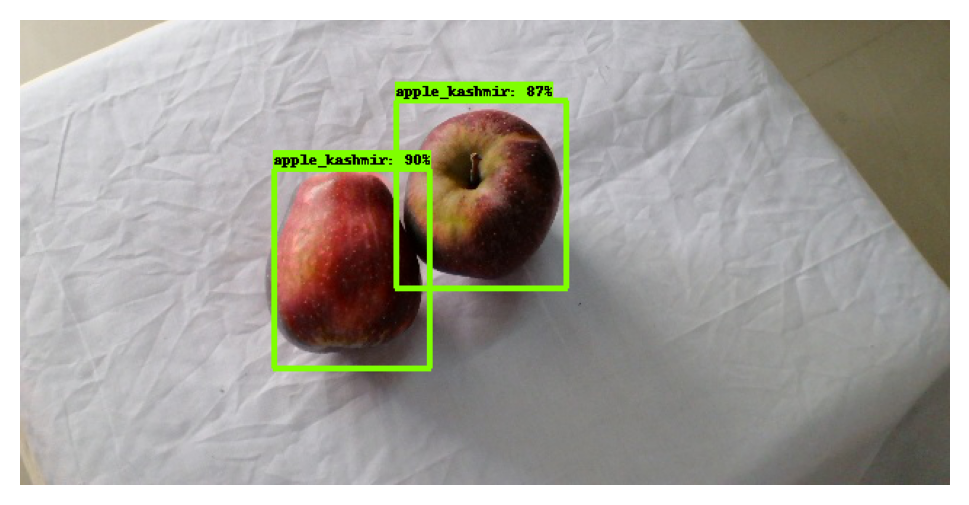

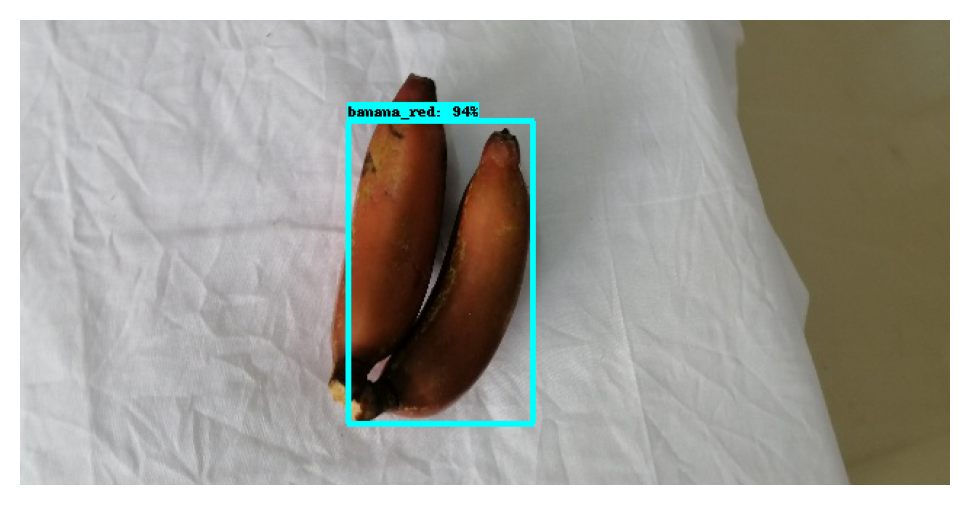

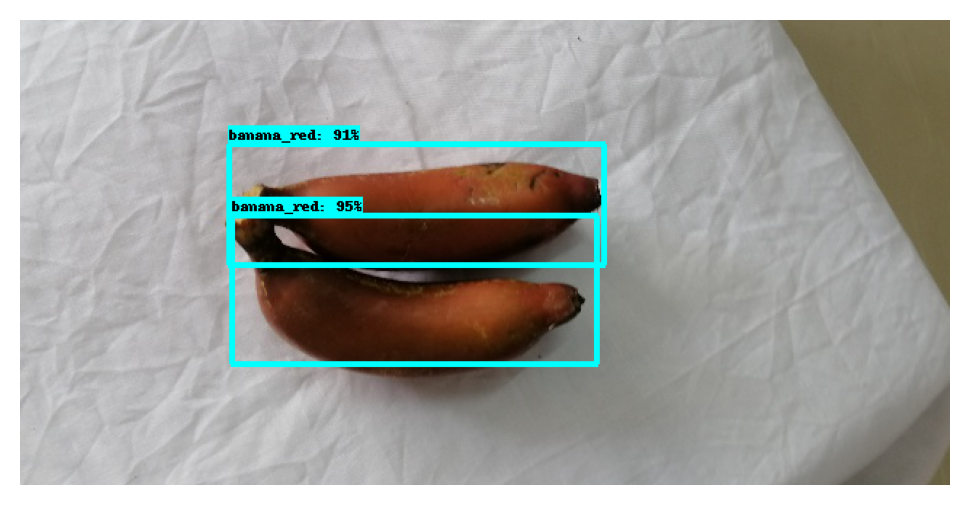

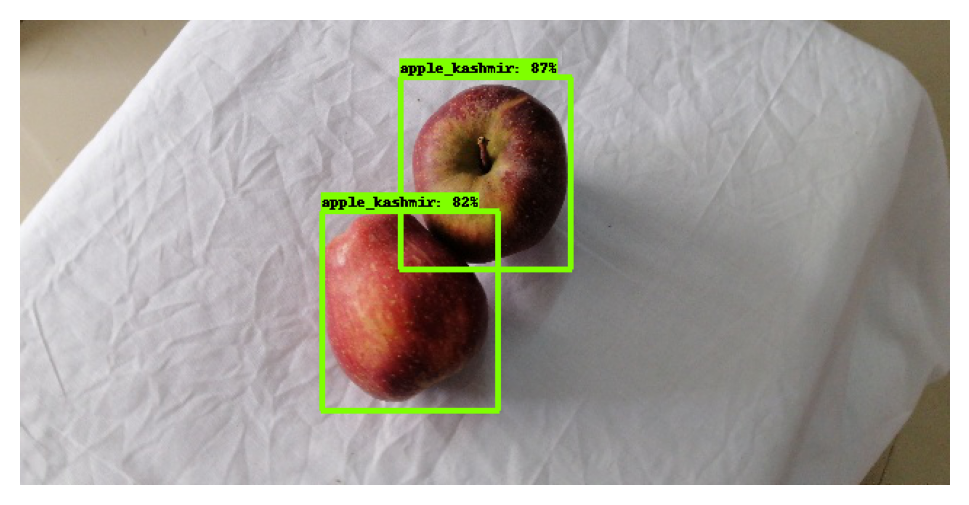

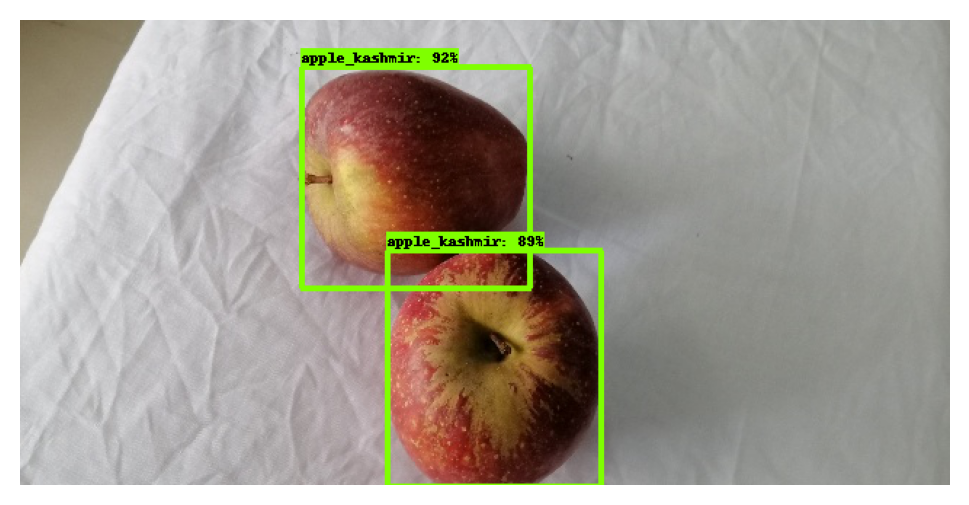

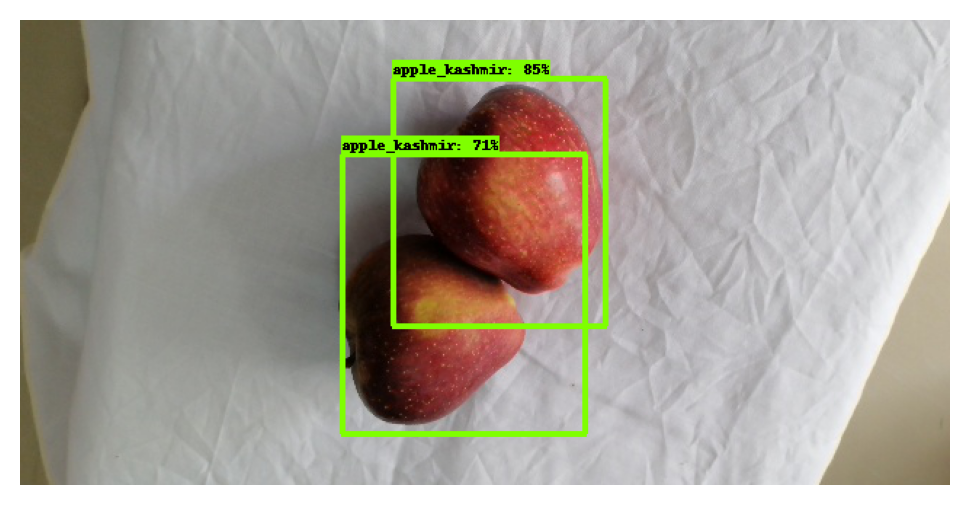

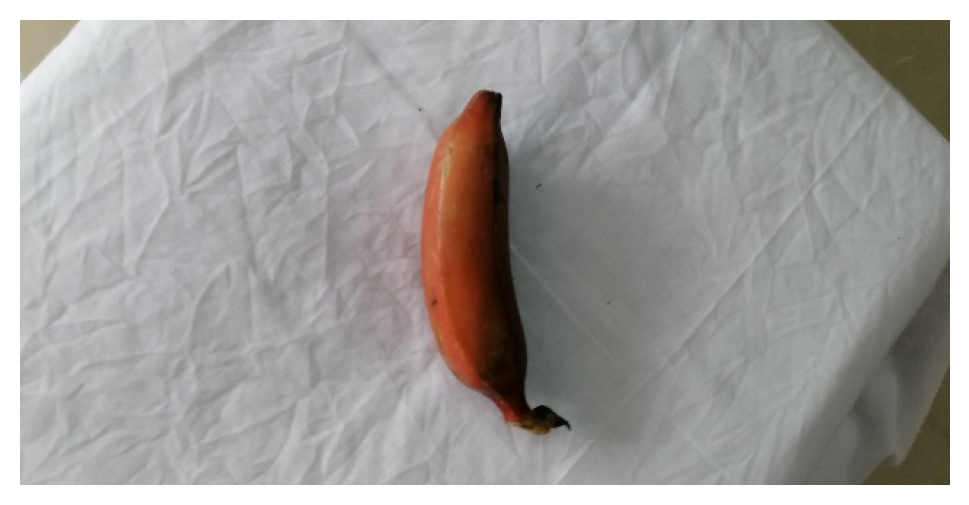

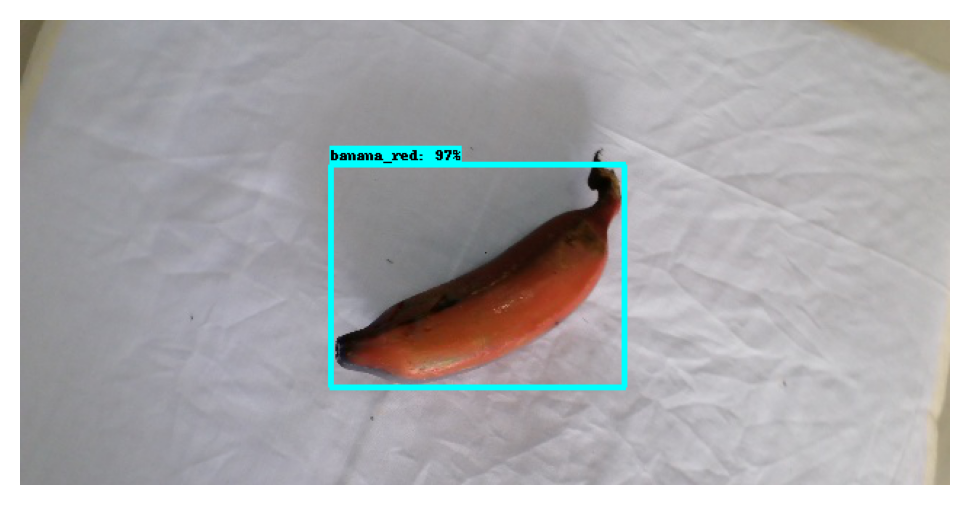

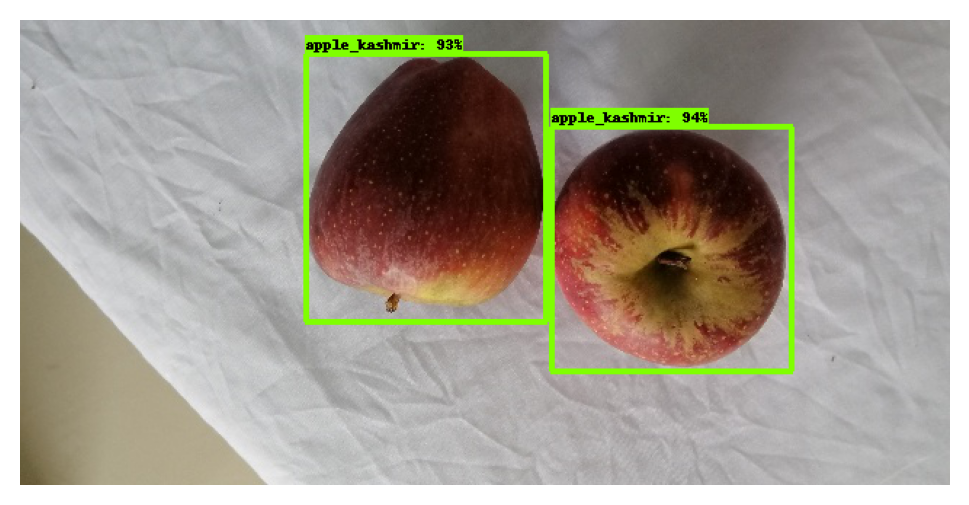

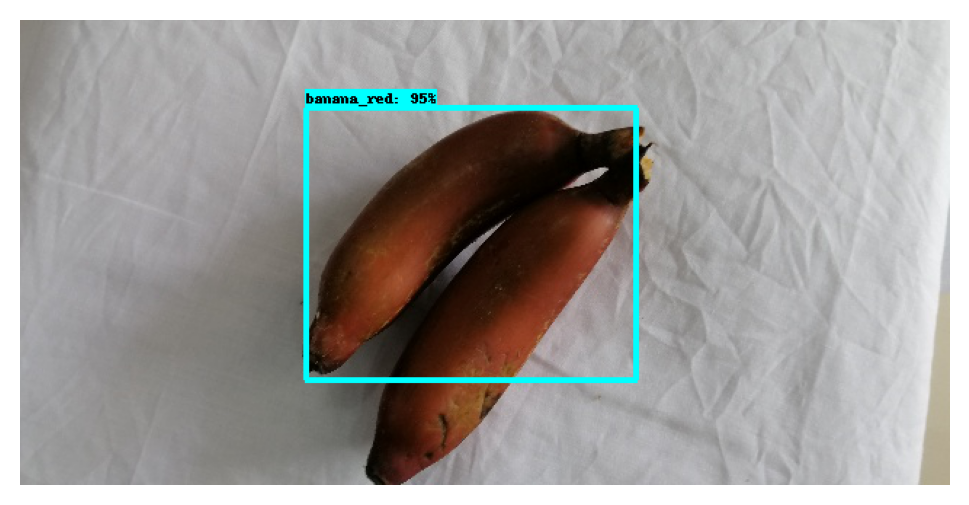

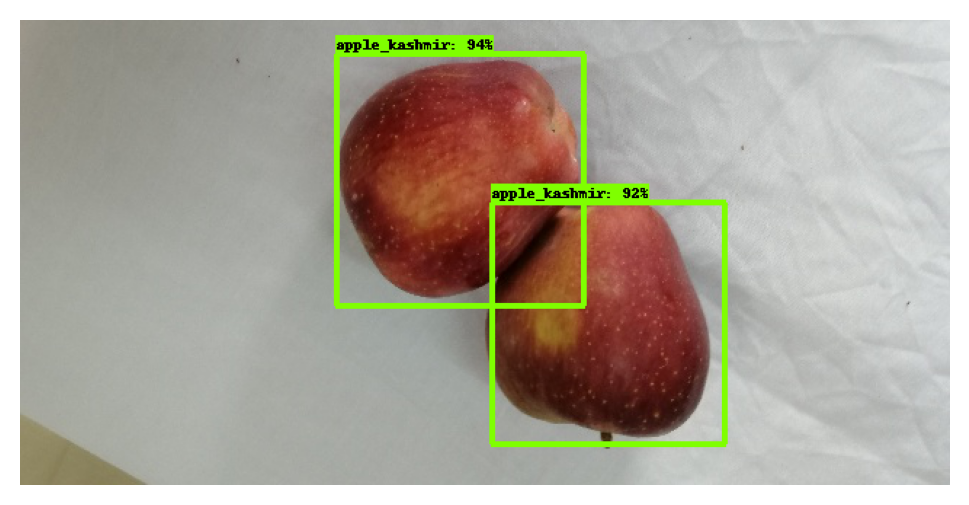

In [46]:
for image_path in Path('training_demo/images/test').glob('*.jpg'):
    img_name = image_path.stem
    
    image_path = str(image_path)
    print('Running inference for {}... '.format(image_path), end='')
    image_np = load_image_into_numpy_array(image_path)
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
    label_id_offset = 1
    image_np_with_detections = image_np.copy()
    
    boxes = detections['detection_boxes']
    scores = detections['detection_scores']
    max_output_size = 20
    
    selected_indices = tf.image.non_max_suppression(
        boxes, scores, max_output_size = max_output_size, iou_threshold=0.5,
        score_threshold=float('-inf'), name=None
    )
    selected_boxes = tf.gather(boxes, selected_indices).numpy()
    selected_classes = tf.gather(detections['detection_classes'], selected_indices).numpy()
    selected_scores = tf.gather(detections['detection_scores'], selected_indices).numpy()
    
    viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            selected_boxes,
            selected_classes+label_id_offset,
            selected_scores,
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=200,
            min_score_thresh=.50,
            agnostic_mode=False)

    plt.figure(dpi = 200)
    plt.imshow(image_np_with_detections)
    plt.axis('off')
    print('Done')
    # plt.show()
    plt.savefig(f'training_demo/predictions/{img_name}.png', bbox_inches='tight')
# sphinx_gallery_thumbnail_number = 2